In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
from check_shapes import check_shapes
from matplotlib.axes import Axes

import gpflow
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [3]:
## Solar radiance
series = pd.read_csv('../data/time_series_solar.csv', index_col="Datetime", parse_dates=True) 

In [4]:
print(series)

                     Incoming Solar
Datetime                           
2007-10-01 00:00:00             0.0
2007-10-01 01:00:00             0.0
2007-10-01 02:00:00             0.0
2007-10-01 03:00:00             0.0
2007-10-01 04:00:00             0.0
...                             ...
2013-09-30 19:00:00             0.0
2013-09-30 20:00:00             0.0
2013-09-30 21:00:00             0.0
2013-09-30 22:00:00             0.0
2013-09-30 23:00:00             0.0

[52608 rows x 1 columns]


In [5]:
# Resample the data to daily frequency
series = series.resample('D').sum()

In [6]:
series_df = series.reset_index()

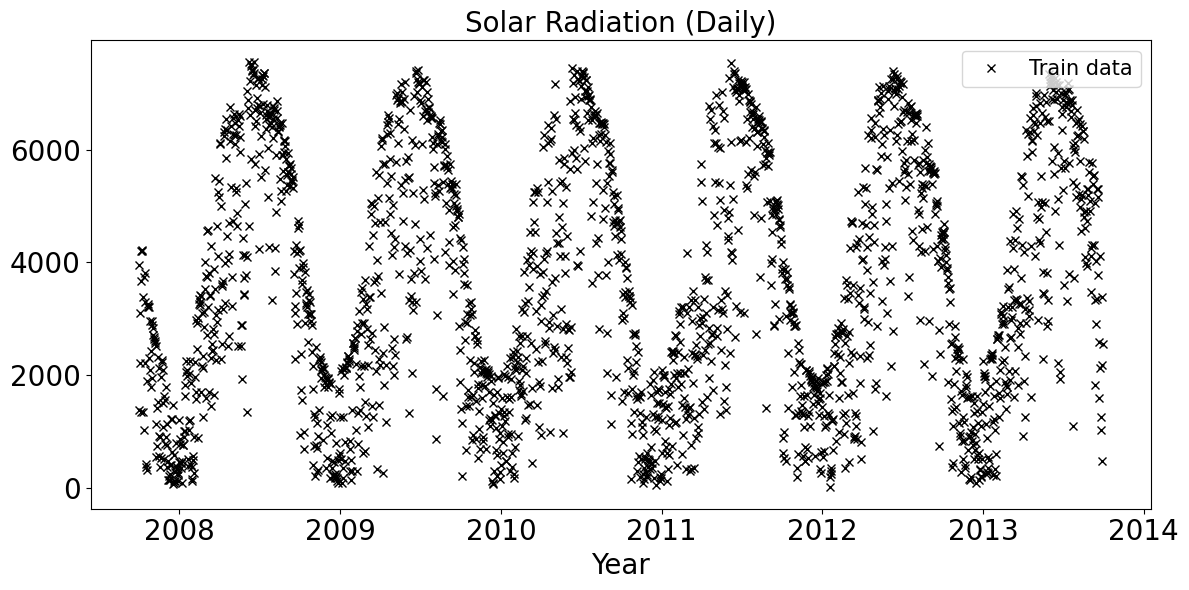

In [7]:
plt.rcParams['figure.figsize'] = [12, 6]
# Plot the data
_, ax = plt.subplots(nrows=1, ncols=1)

ax.plot(series_df['Datetime'], series_df['Incoming Solar'], 'kx', label='Train data')

plt.legend()
plt.xlabel('Year', fontsize=20)
plt.title('Solar Radiation (Daily)', fontsize=20)

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

plt.legend(fontsize=15)
plt.tight_layout()
#plt.xlim(1986, 2024)

plt.savefig('solar_radiation.png')
#plt.show()

### ARIMA forecast

In [8]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [9]:
train_size = int(len(series_df) * 0.8)
train, test = series_df.iloc[:train_size], series_df.iloc[train_size:]

In [10]:
p=1
d=1
q=1
# fit the ARIMA model
# the order tuple (p, d, q) represents the order of the AR, I, and MA parts, respectively
model = ARIMA(train['Incoming Solar'], order=(p, d, q))
model_fit = model.fit()

In [11]:
predictions = []
history = list(train['Incoming Solar'])

for t in range(len(test)):
    model = ARIMA(history, order=(p, d, q))
    model_fit = model.fit()
    forecast = model_fit.forecast()[0]  # Get the one-step forecast
    predictions.append(forecast)
    history.append(test['Incoming Solar'].iloc[t])  # Update history with actual value

In [12]:
mse = mean_squared_error(test['Incoming Solar'], predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 1275020.5989256692


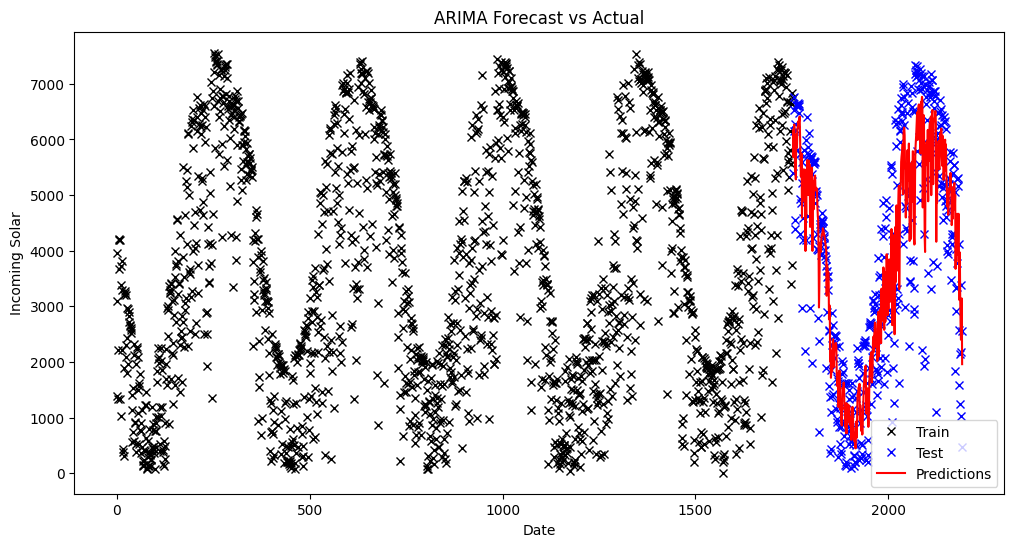

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Incoming Solar'], 'kx', label='Train')
plt.plot(test.index, test['Incoming Solar'], 'bx', label='Test')
plt.plot(test.index, predictions, color='red', label='Predictions')
plt.xlabel('Date')
plt.ylabel('Incoming Solar')
plt.title('ARIMA Forecast vs Actual')
plt.legend()
plt.savefig('figures/Solar_ARIMA_forecast.png')
plt.show()

### Naive forecasts

In [14]:
# Naive forecast
naive_shift = test['Incoming Solar'].shift(1).fillna(train['Incoming Solar'].iloc[-1])

# Seasonal naive forecast
seasonal_shift_lag = 12 #  Replace with the length of your season
seasonal_shift = test['Incoming Solar'].shift(seasonal_shift_lag).fillna(train['Incoming Solar'].iloc[-seasonal_shift_lag])

# Mean forecast
mean_forecast = pd.Series(train['Incoming Solar'].mean(), index=test.index)


In [15]:
# ARIMA forecast MSE (already computed previously)
arima_mse = mean_squared_error(test['Incoming Solar'], predictions)

# Naive shift MSE
naive_shift_mse = mean_squared_error(test['Incoming Solar'], naive_shift)

# Seasonal shift MSE
seasonal_shift_mse = mean_squared_error(test['Incoming Solar'], seasonal_shift)

# Mean forecast MSE
mean_forecast_mse = mean_squared_error(test['Incoming Solar'], mean_forecast)

print(f'ARIMA MSE: {arima_mse/10000}')
print(f'Naive Shift MSE: {naive_shift_mse/10000}')
print(f'Seasonal Shift MSE: {seasonal_shift_mse/10000}')
print(f'Mean Forecast MSE: {mean_forecast_mse/10000}')

ARIMA MSE: 127.50205989256692
Naive Shift MSE: 174.86803032118453
Seasonal Shift MSE: 260.36113431890664
Mean Forecast MSE: 448.28764245284947


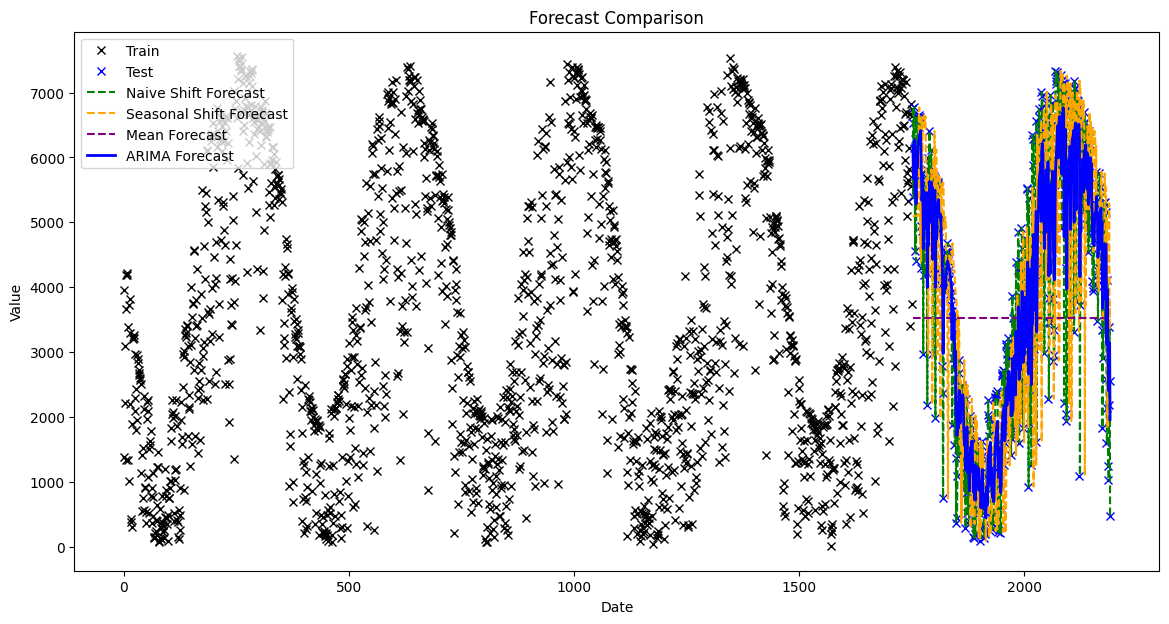

In [16]:
plt.figure(figsize=(14, 7))

# Plot training and test sets
plt.plot(train.index, train['Incoming Solar'], 'kx', label='Train')
plt.plot(test.index, test['Incoming Solar'], 'bx', label='Test')

# Plot Naive Forecasts with distinct colors and thicker lines
plt.plot(test.index, naive_shift, label='Naive Shift Forecast', linestyle='--', color='green', linewidth=1.5)
plt.plot(test.index, seasonal_shift, label='Seasonal Shift Forecast', linestyle='--', color='orange', linewidth=1.5)
plt.plot(test.index, mean_forecast, label='Mean Forecast', linestyle='--', color='purple', linewidth=1.5)

# Plot ARIMA Predictions with a thicker line
plt.plot(test.index, predictions, label='ARIMA Forecast', color='blue', linewidth=2)

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Forecast Comparison')
plt.legend(loc='upper left')
plt.savefig('figures/Solar_forecast_ARIMA_naive.png')

plt.show()
